In [1]:
!pip install pyspark
!pip install findspark
!pip install graphframes-py==0.10.0

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder \
    .appName("SparkGraphFramesExample") \
    .config("spark.jars.packages", "io.graphframes:graphframes-spark3_2.12:0.10.0") \
    .getOrCreate()

In [4]:
spark

In [5]:
# Create a Vertex DataFrame with unique ID column "id"
v = spark.createDataFrame([
    ("a", "Alice", 34),
    ("b", "Bob", 36),
    ("c", "Charlie", 30),
], ["id", "name", "age"])

# Create an Edge DataFrame with "src" and "dst" columns
e = spark.createDataFrame([
    ("a", "b", "friend"),
    ("b", "c", "follow"),
    ("c", "b", "follow"),
], ["src", "dst", "relationship"])


# Create a GraphFrame
from graphframes import *

g = GraphFrame(v, e)

# Query: Get in-degree of each vertex.
g.inDegrees.show()

# Query: Count the number of "follow" connections in the graph.
g.edges.filter("relationship = 'follow'").count()

# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.01, maxIter=20)
results.vertices.select("id", "pagerank").show()

+---+--------+
| id|inDegree|
+---+--------+
|  b|       2|
|  c|       1|
+---+--------+

+---+------------------+
| id|          pagerank|
+---+------------------+
|  b|1.0905890109440908|
|  a|              0.01|
|  c|1.8994109890559092|
+---+------------------+



## Zadania

1. Wczytać graf Facebooka, krawędzie z pliku musae_facebook_edges.csv, atrybuty page_name oraz page_type z pliku musae_facebook_target.csv.  Policzyć liczbę krawędzi i wierzchołków.

In [6]:
edges = spark.read.csv('musae_facebook_edges.csv', header=True).withColumnRenamed("id_1", "src").withColumnRenamed("id_2", "dst")

edges.show(20)

+---+-----+
|src|  dst|
+---+-----+
|  0|18427|
|  1|21708|
|  1|22208|
|  1|22171|
|  1| 6829|
|  1|16590|
|  1|20135|
|  1| 8894|
|  1|15785|
|  1|10281|
|  1|22265|
|  1| 7136|
|  1|22405|
|  1|10379|
|  1|13737|
|  1| 8533|
|  1|14344|
|  1| 2812|
|  1| 5755|
|  1|16260|
+---+-----+
only showing top 20 rows



In [7]:
vertices = spark.read.csv('musae_facebook_target.csv', header=True).select("id", "page_name", "page_type")

vertices.show(20)

+---+--------------------+----------+
| id|           page_name| page_type|
+---+--------------------+----------+
|  0|The Voice of Chin...|    tvshow|
|  1|U.S. Consulate Ge...|government|
|  2|                ESET|   company|
|  3|Consulate General...|government|
|  4|Mark Bailey MP - ...|politician|
|  5| Victor Dominello MP|politician|
|  6|Jean-Claude Poissant|politician|
|  7|Deputado Ademir C...|politician|
|  8|T.C. Mezar-ı Şeri...|government|
|  9|Army ROTC Fightin...|government|
| 10| NASA Student Launch|government|
| 11|       Eliziane Gama|politician|
| 12|     Socialstyrelsen|government|
| 13|Brisbane Water LA...|government|
| 14|NASA's Marshall S...|government|
| 15|Municipio de Loma...|government|
| 16|  Die Techniker (TK)|   company|
| 17|     Digvijaya Singh|politician|
| 18|1st Armored Divis...|government|
| 19|           Shapeways|   company|
+---+--------------------+----------+
only showing top 20 rows



In [8]:
graph = GraphFrame(vertices, edges)

graph.vertices.count()

22470

In [9]:
graph.edges.count()

171002

2. Sprawdzić czy graf jest spójny. Czy dwa podgrafy utworzone dla typów strony governmental organizations oraz television shows też są spójne?


In [10]:
sc = spark.sparkContext
sc.setCheckpointDir("/tmp/spark-checkpoints")

In [11]:
components = graph.connectedComponents()

components.select("id", "component").show(5)

+---+---------+
| id|component|
+---+---------+
|  0|        0|
|  1|        0|
|  2|        0|
|  3|        0|
|  4|        0|
+---+---------+
only showing top 5 rows



In [12]:
number_of_components = components.select("component").distinct().count()
if number_of_components == 1:
    print("The graph is connected.")
else:
  print(f"The graph is not connected. Number of components {number_of_components}.")

The graph is connected.


In [13]:
types = ['governmental organizations', 'television shows']

for type in types:
  sub_graph_vertices = graph.vertices.filter(f"page_type = '{type}'")
  sub_graph = GraphFrame(sub_graph_vertices, graph.edges)

  components = sub_graph.connectedComponents()
  number_of_components = components.select("component").distinct().count()
  if number_of_components == 1:
    print(f"A subgraph with vertices of type {type} is connected.")
  else:
    print(f"A subgraph with vertices of type {type} is not connected. Number of components {number_of_components}.")


A subgraph with vertices of type governmental organizations is not connected. Number of components 0.
A subgraph with vertices of type television shows is not connected. Number of components 0.


Z tego wynika, że graf jest pusty, ponieważ nie znalazł żadnych spójnych składowych w grafie. Sprawdzenie:

In [14]:
sub_graph_vertices = graph.vertices.filter("page_type = 'governmental organizations'")
sub_graph = GraphFrame(sub_graph_vertices, graph.edges)
print(sub_graph.vertices.count())
print(sub_graph.edges.count())

0
171002


3. Spośród 500 stron o najwyższym PageRank znaleźć 20 takich (wypisać page_name i page_type), które mają najmniej połączeń oraz 20 o największej liczbie połączeń. Który typ strony był dominujący w każdej z tych kategorii? Narysować wykres zależności PageRank od liczby krawędzi dla wierzchołków (scatter plot)

In [15]:
pagerank = graph.pageRank(resetProbability=0.01, maxIter=20)
degrees = graph.degrees
highest500 = pagerank.vertices.join(degrees, "id").orderBy(col("pagerank").desc()).limit(500)
orderedByDegreeAsc = highest500.select("page_name", "page_type").orderBy(col("degree"))
orderedByDegreeDesc = highest500.select("page_name", "page_type").orderBy(col("degree").desc())

In [16]:
highest20 = orderedByDegreeDesc.limit(20)
highest20.toPandas()

,page_name,page_type
0,U.S. Army,government
1,The White House,government
2,The Obama White House,government
3,U.S. Army Chaplain Corps,government
4,U.S. Department of State,government
5,FEMA Federal Emergency Management Agency,government
6,European Parliament,government
7,United States Air Force,government
8,"Los Angeles District, U.S. Army Corps of Engin...",government
9,Barack Obama,politician


In [17]:
lowest20 = orderedByDegreeAsc.limit(20)
lowest20.toPandas()

,page_name,page_type
0,New Balance Brasil,company
1,Kinder,company
2,adidas Women,company
3,spark7,company
4,Viessmann,company
5,"Bom dia Amazônia, Jornal do AC e G1 AC",tvshow
6,Samsung,company
7,Oracle Latin America,company
8,El Mundo Del Dulce,company
9,Allianz Polska,company


In [18]:
print("Highest degree:")
highest20.groupBy("page_type").count().orderBy(col("count").desc()).show()
print("Lowest degree:")
lowest20.groupBy("page_type").count().orderBy(col("count").desc()).show()

Highest degree:
+----------+-----+
| page_type|count|
+----------+-----+
|government|   17|
|politician|    3|
+----------+-----+

Lowest degree:
+----------+-----+
| page_type|count|
+----------+-----+
|   company|   16|
|    tvshow|    3|
|government|    1|
+----------+-----+



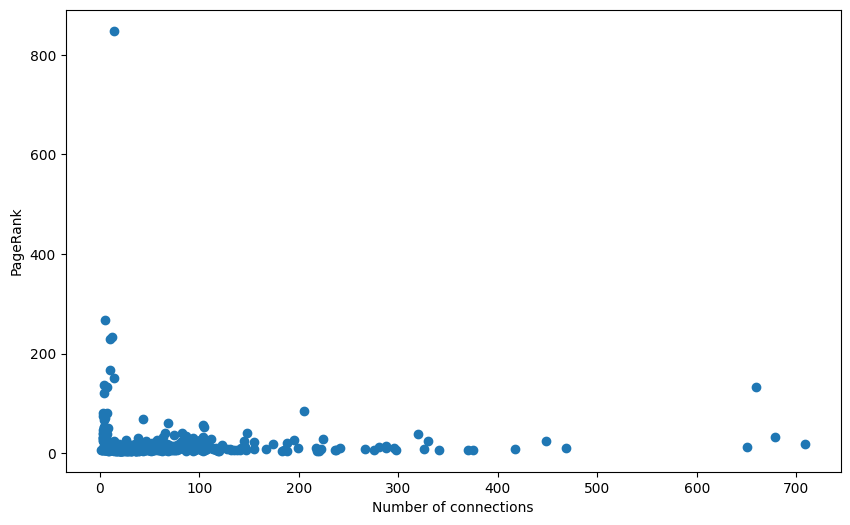

In [19]:
import matplotlib.pyplot as plt

highest500_pd = highest500.toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(highest500_pd["degree"], highest500_pd["pagerank"])
plt.xlabel("Number of connections")
plt.ylabel("PageRank")
plt.show()

4. Korzystając z Pregel API zaimplementować następujący algorytm. W pierwszym kroku wybrana strona publikuje post fake news. W kolejnym kroku ten post publikowany jest przez 1/3 losowo wybranych kontaktów tej strony. W dalszych krokach, dla każdej strony, która opublikowała już ten post, losowo wybrane 1/3 jej kontaktów publikuje go u siebie. Pokazać jak zmienia się liczba stron które opublikowały post w zależności od liczby kroków. Opcjonalnie: Sprawdzić powyższą zależność dla współczynnika innego niż 1/4.

In [20]:
from pyspark.sql.functions import when, col, lit, coalesce, greatest
from pyspark.sql import functions as F
from graphframes import GraphFrame
from graphframes.lib import Pregel
import matplotlib.pyplot as plt

In [21]:
def fake_news_simulation(graph, initial_vertex_id, propagation_ratio=0.25, max_steps=5):
    vertices = graph.vertices.withColumn(
        "activated",
        when(col("id") == initial_vertex_id, lit(1.0)).otherwise(lit(0.0))
    ).select("id", "activated")

    edges = graph.edges.select("src", "dst")

    g = GraphFrame(vertices, edges)
    history = []

    edges = g.edges

    for step in range(max_steps):
        active_count = g.vertices.filter(col("activated") > 0).count()
        history.append(active_count)

        pregel_result = g.pregel \
            .setMaxIter(1) \
            .withVertexColumn(
                "activated_new",
                col("activated"),
                greatest(col("activated"), Pregel.msg())
            ) \
            .sendMsgToDst(
                when(Pregel.src("activated") > 0, lit(propagation_ratio)).otherwise(lit(0.0))
            ) \
            .aggMsgs(
                coalesce(F.max(Pregel.msg()), lit(0.0))
            ) \
            .run()

        g = GraphFrame(
            pregel_result.select("id", col("activated_new").alias("activated")),
            edges
        )


    final_count = g.vertices.filter(col("activated") > 0).count()
    history.append(final_count)

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(history)), history, marker='o')
    plt.xlabel("Steps")
    plt.ylabel("Number of infected vertices")
    plt.title(f"Fake news with ratio {propagation_ratio} in {max_steps} steps")
    plt.grid(True)
    plt.show()

    print(f"Total number of vertices: {g.vertices.count()}")

    return g, history


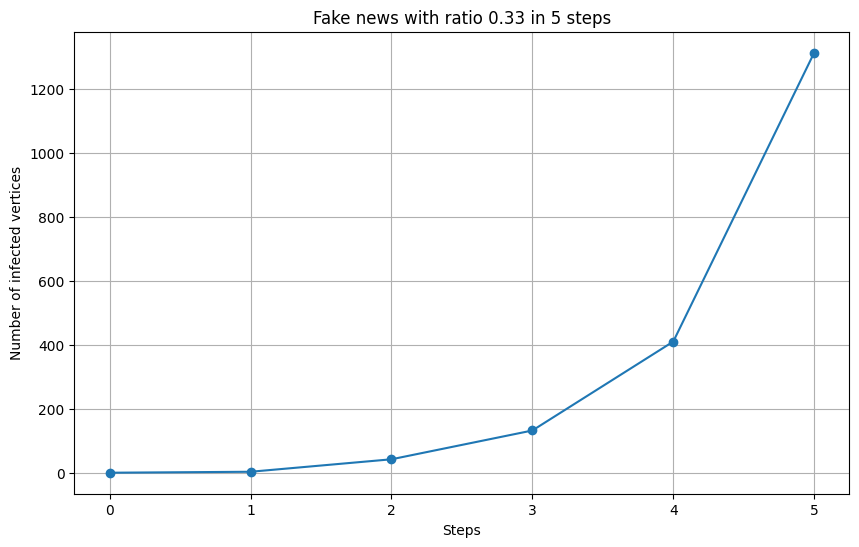

Total number of vertices: 22470


(GraphFrame(v:DataFrame[id: string, activated: double], e:DataFrame[src: string, dst: string]),
 [1, 4, 43, 133, 411, 1314])

In [22]:
fake_news_simulation(graph, initial_vertex_id = "8", propagation_ratio=0.33, max_steps=5)

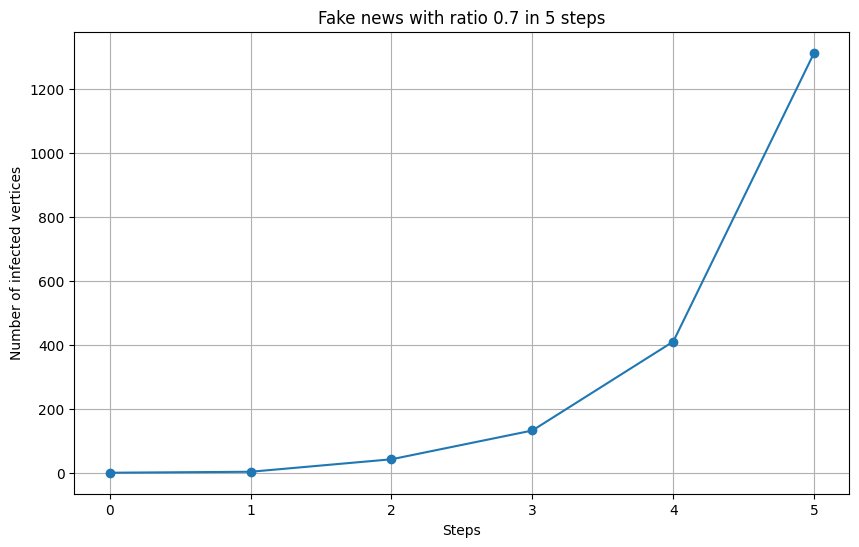

Total number of vertices: 22470


(GraphFrame(v:DataFrame[id: string, activated: double], e:DataFrame[src: string, dst: string]),
 [1, 4, 43, 133, 411, 1314])

In [23]:
fake_news_simulation(graph, initial_vertex_id = "8", propagation_ratio=0.7, max_steps=5)

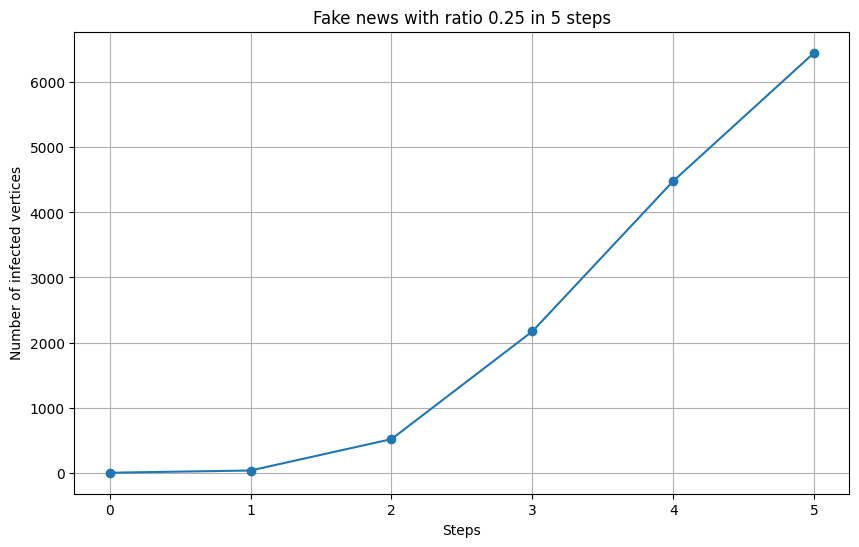

Total number of vertices: 22470


(GraphFrame(v:DataFrame[id: string, activated: double], e:DataFrame[src: string, dst: string]),
 [1, 35, 517, 2172, 4482, 6453])

In [24]:
fake_news_simulation(graph, initial_vertex_id = "1", propagation_ratio=0.25, max_steps=5)

5. Narysować wykres rozkładu stopnia wierzchołków w grafie w skali logarytmicznej. Można skorzystać z funkcji stat.approxQuantile.  Czy sieć jest bezskalowa (scale-free)? https://barabasi.com/media/pub_imports/files/623.pdf

In [25]:
degrees = graph.degrees
degree_counts = degrees.groupBy("degree").count().orderBy("degree").toPandas()

x = degree_counts['degree']
y = degree_counts['count']

In [26]:
quantiles = degrees.approxQuantile("degree", [0.25, 0.5, 0.75, 0.95], 0.01)
print("Kwantyle stopni:", quantiles)

Kwantyle stopni: [3.0, 7.0, 17.0, 50.0]


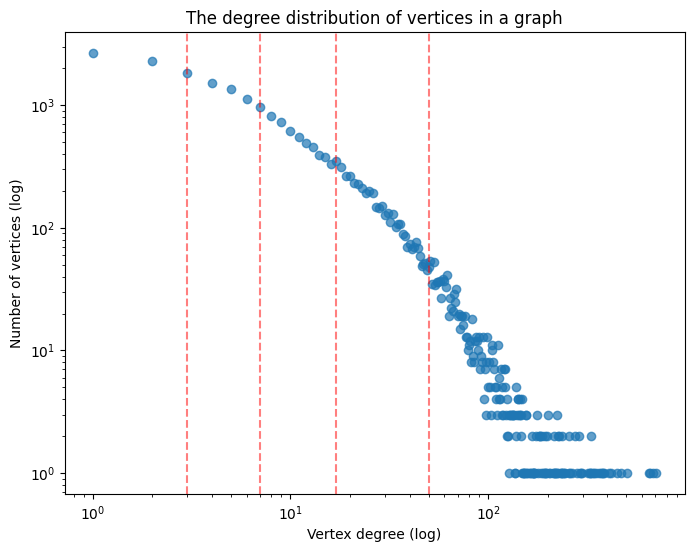

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.7)
plt.xscale('log')
plt.yscale('log')

for q in quantiles:
    plt.axvline(x=q, color='red', linestyle='--', alpha=0.5)

plt.xlabel('Vertex degree (log)')
plt.ylabel('Number of vertices (log)')
plt.title('The degree distribution of vertices in a graph')
plt.show()
